In [86]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import requests

from sklearn import svm
from skrebate import ReliefF
from scipy.stats import zscore
from scipy.stats import f_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from itertools import combinations

sns.set_theme(style='white', font_scale=1.8)

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.autolayout'] = True

In [87]:
# Define the file paths
prot_file_path = '../Data/CCFData/Exercise Proteomics, Metabolomics and RNAseq/2. Exercise Tissue Proteomics/Exercise Mice RAW MUSCLE PROTOEMICS .xlsx'
rna_file_path = '../Data/CCFData/Exercise Proteomics, Metabolomics and RNAseq/3. Exercise Tissue RNAseq/EXERCISE MICE RNA SEQ TISSUE Normalized count.csv'

# Read the Excel file and set the first column as the index
df_prot = pd.read_excel(prot_file_path, engine='openpyxl', index_col=0, skiprows=1)
df_prot.reset_index(inplace=True)
# df_prot.set_index("ProteinDescriptions", inplace=True)

# Read the CSV file and set the first column as the index
df_rna = pd.read_csv(rna_file_path, index_col=0)

# List of new column names starting from the 4th column
new_column_names = (
    ["NE PBS " + str(i) for i in range(1, 9)] +
    ["NE AmAc " + str(i) for i in range(1, 9)] +
    ["E PBS " + str(i) for i in range(1, 9)] +
    ["E AmAc " + str(i) for i in range(1, 9)]
)

# Renaming columns starting from the 5th column
df_prot.columns = list(df_prot.columns[:4]) + new_column_names
df_prot = df_prot.drop("E PBS 6", axis = 1)

# Load the gene annotation data
gene_annotation_file_path = "../Data/CCFData/Exercise Proteomics, Metabolomics and RNAseq/3. Exercise Tissue RNAseq/NoExAm_vs_NoExPBS_DEResults_wNormCounts.csv"
gene_annotation_data = pd.read_csv(gene_annotation_file_path)

# Create the Ensembl ID to gene name dictionary
ensembl_to_gene_name_dict = pd.Series(gene_annotation_data.external_gene_name.values, index=gene_annotation_data.Ensembl_ID).to_dict()

# Rename the indexes using the Ensembl ID to gene name dictionary
df_rna.rename(index=ensembl_to_gene_name_dict, inplace=True)

In [88]:
df_rna.head()

,NE PBS 1,NE PBS 2,NE PBS 3,NE PBS 4,NE PBS 5,NE PBS 6,NE PBS 7,NE PBS 8,NE AmAc 1,NE AmAc 2,...,E PBS 7,E PBS 8,E AmAc 1,E AmAc 2,E AmAc 3,E AmAc 4,E AmAc 5,E AmAc 6,E AmAc 7,E AmAc 8
Gm37671,1.022611,1.022611,2.145525,1.050310,1.045734,1.045734,1.036075,1.045734,1.023115,1.022611,...,1.045734,1.020511,1.022611,1.029207,1.059502,2.045223,0.981492,1.118287,1.022611,1.077105
Gm8941,1.022611,2.045223,1.072762,1.050310,1.045734,1.045734,1.036075,1.045734,1.023115,1.022611,...,1.045734,1.020511,1.022611,4.116829,1.059502,1.022611,0.981492,1.118287,1.022611,1.077105
Gm15178,3.067834,1.022611,1.072762,3.150929,2.091468,3.137202,1.036075,3.137202,4.092461,8.180891,...,1.045734,5.102556,3.067834,1.029207,2.119003,1.022611,0.981492,1.118287,1.022611,4.308420
Gm37108,2.045223,4.090446,1.072762,2.100619,4.182937,2.091468,1.036075,3.137202,3.069346,4.090446,...,4.182937,1.020511,1.022611,3.087621,2.119003,1.022611,3.925969,4.473147,1.022611,2.154210
Gm29155,3.067834,1.022611,3.218287,2.100619,1.045734,2.091468,1.036075,1.045734,2.046230,3.067834,...,1.045734,7.143578,1.022611,1.029207,2.119003,1.022611,1.962985,3.354861,1.022611,1.077105


In [89]:
df_prot.head()

,ProteinDescriptions,Accessions,Genes,MW[Da],NE PBS 1,NE PBS 2,NE PBS 3,NE PBS 4,NE PBS 5,NE PBS 6,...,E PBS 7,E PBS 8,E AmAc 1,E AmAc 2,E AmAc 3,E AmAc 4,E AmAc 5,E AmAc 6,E AmAc 7,E AmAc 8
0,(E3-independent) E2 ubiquitin-conjugating enzy...,Q6ZPJ3,Ube2o,140833.83,56.437660,54.092911,42.372314,45.800488,59.371269,52.451572,...,43.976284,55.716457,62.781155,49.701450,59.557568,53.518085,46.780411,45.900673,58.912094,49.847664
1,[3-methyl-2-oxobutanoate dehydrogenase [lipoam...,O55028,Bckdk,46587.51,123.185471,119.996094,105.292595,117.121948,152.500519,99.123581,...,77.200394,108.595825,104.280113,104.833633,150.370773,101.111382,119.781860,91.712593,83.894806,81.437294
2,[Protein ADP-ribosylarginine] hydrolase,P54923,Adprh,40068.28,148.589859,162.838333,189.672501,148.339981,175.079330,197.352600,...,180.886322,187.020584,171.491669,169.619080,161.312973,184.240341,190.629486,183.497787,195.009506,183.457550
3,[Protein ADP-ribosylarginine] hydrolase-like p...,Q8BGK2,Adprhl1,39885.25,182.243042,59.611561,67.129524,74.647133,93.298645,85.076218,...,71.856995,77.581680,78.159836,78.642662,80.394066,78.888962,147.358643,68.065674,82.403549,66.139366
4,[Pyruvate dehydrogenase (acetyl-transferring)]...,Q8BFP9,Pdk1,48995.01,115.922745,88.738937,93.658630,129.272018,121.103943,74.227509,...,96.603951,96.334366,94.712318,91.213295,81.711433,85.413445,102.138542,100.460770,102.668976,86.268761


In [92]:
# Filter columns with data, transpose, and normalize using z-score
df_prot_normalized = df_prot[df_prot.columns[4:]].T.apply(zscore, axis=0)

# Assuming df_prot is your DataFrame
protein_gene_dict = df_prot.set_index('ProteinDescriptions')['Genes'].to_dict()

# Assign the values as the new column names
df_prot_normalized.columns = list(protein_gene_dict.values())
df_prot_normalized.columns = df_prot_normalized.columns.astype(str)

df_prot_normalized.head()

,Ube2o,Bckdk,Adprh,Adprhl1,Pdk1,Pdk2,Pdk4,Pdp1,Adi1,Gbe1,...,Yrdc,Zbtb20,Zc3h15,Zc3h18,Zcchc8,Znf428,Znf830,Zpr1,Azgp1,Zyx
NE PBS 1,0.506317,1.056973,-1.820748,2.774022,1.173897,0.080968,-0.702425,0.302572,0.431775,1.511515,...,-0.801332,0.245353,0.109853,1.374338,-1.009657,0.333360,-0.606087,0.053244,1.578097,-0.182944
NE PBS 2,0.113496,0.887992,-0.870756,-0.706154,-0.594518,-1.064906,-0.865336,-0.582937,0.842476,0.926369,...,-1.308502,-0.496994,0.890230,-0.731880,-0.682785,1.752249,1.464833,-0.973171,0.919719,-0.585467
NE PBS 3,-1.850081,0.108964,0.918366,-0.492800,-0.274472,-0.077718,-1.331108,1.211319,-0.292281,-1.208035,...,1.326537,-0.032295,1.410249,1.103847,0.991653,0.123816,-1.594221,1.793311,0.062721,0.071671
NE PBS 4,-1.275752,0.735713,-1.837408,-0.279457,2.042321,-1.117083,-0.936810,-1.112737,0.340203,-0.234965,...,-1.130577,0.722952,1.637701,0.816101,-1.033900,1.003987,0.929810,1.641064,0.215762,-0.888152
NE PBS 5,0.997790,2.610157,-0.054609,0.249857,1.510955,1.310159,0.277051,0.554671,0.133149,-0.295867,...,1.488630,-0.323779,0.690521,0.947866,-1.168104,-0.504362,1.107099,1.501562,-1.473518,-0.673816


In [93]:
# Filter rows where 70% of the values are below 10, transpose, and normalize using z-score
df_rna_normalized = df_rna[df_rna.lt(10).mean(axis=1) > 0.7].T.apply(zscore, axis=0)
df_rna_normalized.head()

,Gm37671,Gm8941,Gm15178,Gm37108,Gm29155,C730036E19Rik,Gm29157,Gm29156,Gm47985,Gm8947,...,ENSMUSG00000079222,ENSMUSG00000094874,Csprs,ENSMUSG00000096808,ENSMUSG00000096728,ENSMUSG00000095092,ENSMUSG00000079192,ENSMUSG00000094915,ENSMUSG00000079808,ENSMUSG00002075729
NE PBS 1,-0.325909,-0.328636,0.443942,-0.365535,0.476934,2.852179,-0.693301,-0.367150,1.779932,3.995069,...,0.237017,-0.326954,1.652532,-0.265095,-0.276264,-0.326954,-0.348094,-0.412422,-0.958082,-0.381889
NE PBS 2,-0.325909,1.227684,-0.811060,1.474267,-0.815107,-0.376630,-0.693301,-0.367150,2.601615,0.928730,...,1.251732,-0.326954,0.521227,-0.265095,-0.276264,-0.326954,-0.348094,-0.412422,-0.343474,-0.381889
NE PBS 3,3.981283,-0.252311,-0.780286,-1.240321,0.571981,-0.218282,0.566428,-0.316190,-0.384357,-0.593698,...,-0.727934,-0.133685,-0.554596,-0.008786,-0.003506,-0.133685,-0.232429,-0.339442,-0.283191,-0.219735
NE PBS 4,-0.219667,-0.286482,0.494931,-0.315702,-0.134091,-0.289175,0.516051,-0.872627,-0.677698,-0.598507,...,1.334185,-0.220213,0.582512,-0.123537,-0.125622,-0.220213,-0.284213,-0.372116,1.583584,-0.292332
NE PBS 5,-0.237217,-0.293446,-0.155181,1.557468,-0.800500,-0.303622,-0.667361,-0.343655,0.161339,-0.151533,...,0.282905,3.792143,-0.584497,-0.146921,-0.150506,3.792143,2.117047,-0.378774,-0.944185,-0.307126


In [96]:
# Create label arrays based on column names for df_rna
labels_rna = []
for col in df_rna.columns:
    if col.startswith('NE PBS'):
        labels_rna.append(0)
    elif col.startswith('NE AmAc'):
        labels_rna.append(1)
    elif col.startswith('E PBS'):
        labels_rna.append(2)
    elif col.startswith('E AmAc'):
        labels_rna.append(3)

# Create label arrays based on column names for df_prot
labels_prot = []
for col in df_prot.columns:
    if col.startswith('NE PBS'):
        labels_prot.append(0)
    elif col.startswith('NE AmAc'):
        labels_prot.append(1)
    elif col.startswith('E PBS'):
        labels_prot.append(2)
    elif col.startswith('E AmAc'):
        labels_prot.append(3)

# CASE I - NE_PBS (0) vs. E_PBS (2)

In [97]:
N_reliefF = 100
K = 3

In [98]:
# Convert labels_rna to a Series to utilize boolean indexing
labels_rna_series = pd.Series(labels_rna, index=df_rna_normalized.index)

# Generate the mask where the value is 0 or 2
mask_I = labels_rna_series.isin([0, 2])

# Create the labels_I dataframe
labels_I = pd.DataFrame(index=df_rna_normalized.index)
labels_I['Label'] = df_rna_normalized.index.map(lambda x: 0 if x.startswith('NE PBS') else (1 if x.startswith('E PBS') else None))

# Drop rows where the label could not be assigned (i.e., None values)
labels_I.dropna(inplace=True)

# Generate the mask where the value is 0 or 1
mask_II = labels_rna_series.isin([0, 1])

# Create the labels_II dataframe
labels_II = pd.DataFrame(index=df_rna_normalized.index)
labels_II['Label'] = df_rna_normalized.index.map(lambda x: 0 if x.startswith('NE PBS') else (1 if x.startswith('NE Am') else None))

# Drop rows where the label could not be assigned (i.e., None values)
labels_II.dropna(inplace=True)

c:\Users\fetsuruk\AppData\Local\anaconda3\envs\CCF\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


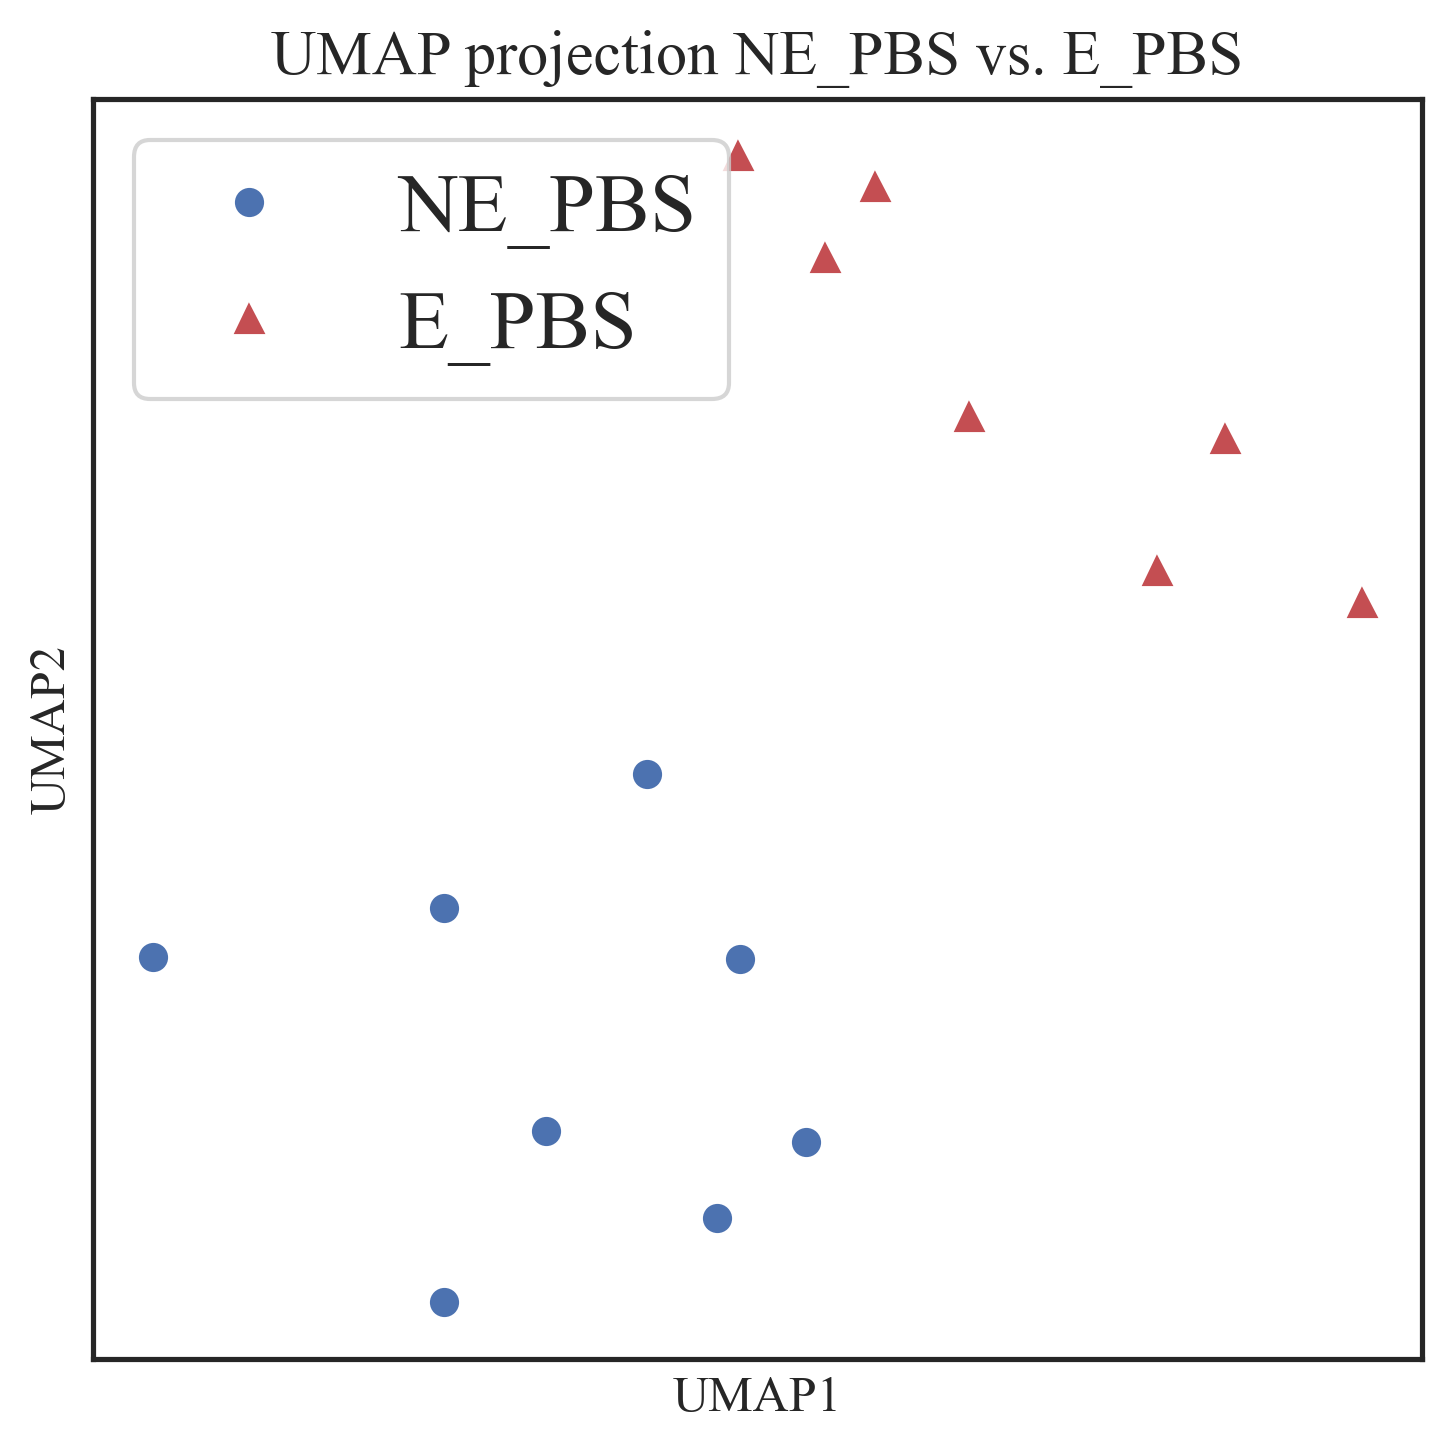

In [99]:
# Select features that separate NE_PBS (0) vs. E_PBS (2)
fs = ReliefF(n_neighbors = K, n_features_to_select = N_reliefF, n_jobs = -1, )
fs.fit(df_prot_normalized[mask_I].values, labels_I['Label'])
df_prot_relief = df_prot_normalized[df_prot_normalized.columns[fs.top_features_[:N_reliefF]]]
# Step 3: Plot UMAP of df_prot_relief
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_prot_relief)

# Plotting
x = embedding[:, 0]
y = embedding[:, 1]
plt.figure()
plt.plot(x[np.equal(labels_prot,0)], y[np.equal(labels_prot,0)], 'bo', label = "NE_PBS")
plt.plot(x[np.equal(labels_prot,2)], y[np.equal(labels_prot,2)], 'r^', label = "E_PBS")

plt.title('UMAP projection NE_PBS vs. E_PBS', fontsize=15)
plt.legend()
plt.xticks([])
plt.yticks([])  
plt.xlabel('UMAP1', fontsize=12)
plt.ylabel('UMAP2', fontsize=12)
plt.show()

In [100]:
df_prot_normalized.columns[fs.top_features_[:N_reliefF]]

Index(['Lmnb1', 'Sptb', 'Ilf2', 'Cox5b', 'Smyd2', 'Pebp1', 'Lrpprc', 'Emc2',
       'Ugp2', 'Flnc', 'Zc3h15', 'Btf3l4', 'Hgs', 'Obscn', 'Sephs1', 'Asrgl1',
       'Maip1', 'Ogdh', 'Erc1', 'Pef1', 'Ttn', 'Nt5c3a', 'Sod2', 'Wdr26',
       'Kctd9', 'Ddx5', 'Bub3', 'Ptrh2', 'Ncbp1', 'Nme2', 'Hsp90ab1', 'Col5a2',
       'Cndp2', 'Dld', 'U2af1', 'Psmb4', 'Ubxn6', 'Naa50', 'Kpna6', 'Phkb',
       'H2ac21', 'Rsu1', 'Cpped1', 'Spryd4', 'Otud4', 'Cbx3', 'Setd3',
       'Arl6ip5', 'Txnl1', 'Ndufb5', 'Tmed2', 'Numa1', 'Nol3', 'Xirp1',
       'Clic5', 'Rad21', 'Cfl2', 'Bzw2', 'Ace', 'Acyp2', 'Adss1', 'Tbc1d1',
       'Dffa', 'Twf2', 'Lamtor1', 'Ndufv1', 'Klhl41', 'Mtx2', 'Aga', 'Anxa6',
       'Psmd4', 'Tmem43', 'Inpp1', 'Atp1b1', 'Myh3', 'Tnni2', 'Scrn3', 'Phb2',
       'Prkaca', 'Atox1', 'Bves', 'Immt', 'Kpna1', 'Hsd17b4', 'Phb', 'Rab1A',
       'Ate1', 'Hnrnpl', 'Ppil1', 'Atp6v1g1', 'Atp5f1d', 'Gmppa', 'Dnaja3',
       'Hcfc1', 'Uqcrfs1', 'Suclg2', 'Diaph1', 'Hnrnpa1', 'Mrpl21', 'Urod'],
      d

c:\Users\fetsuruk\AppData\Local\anaconda3\envs\CCF\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


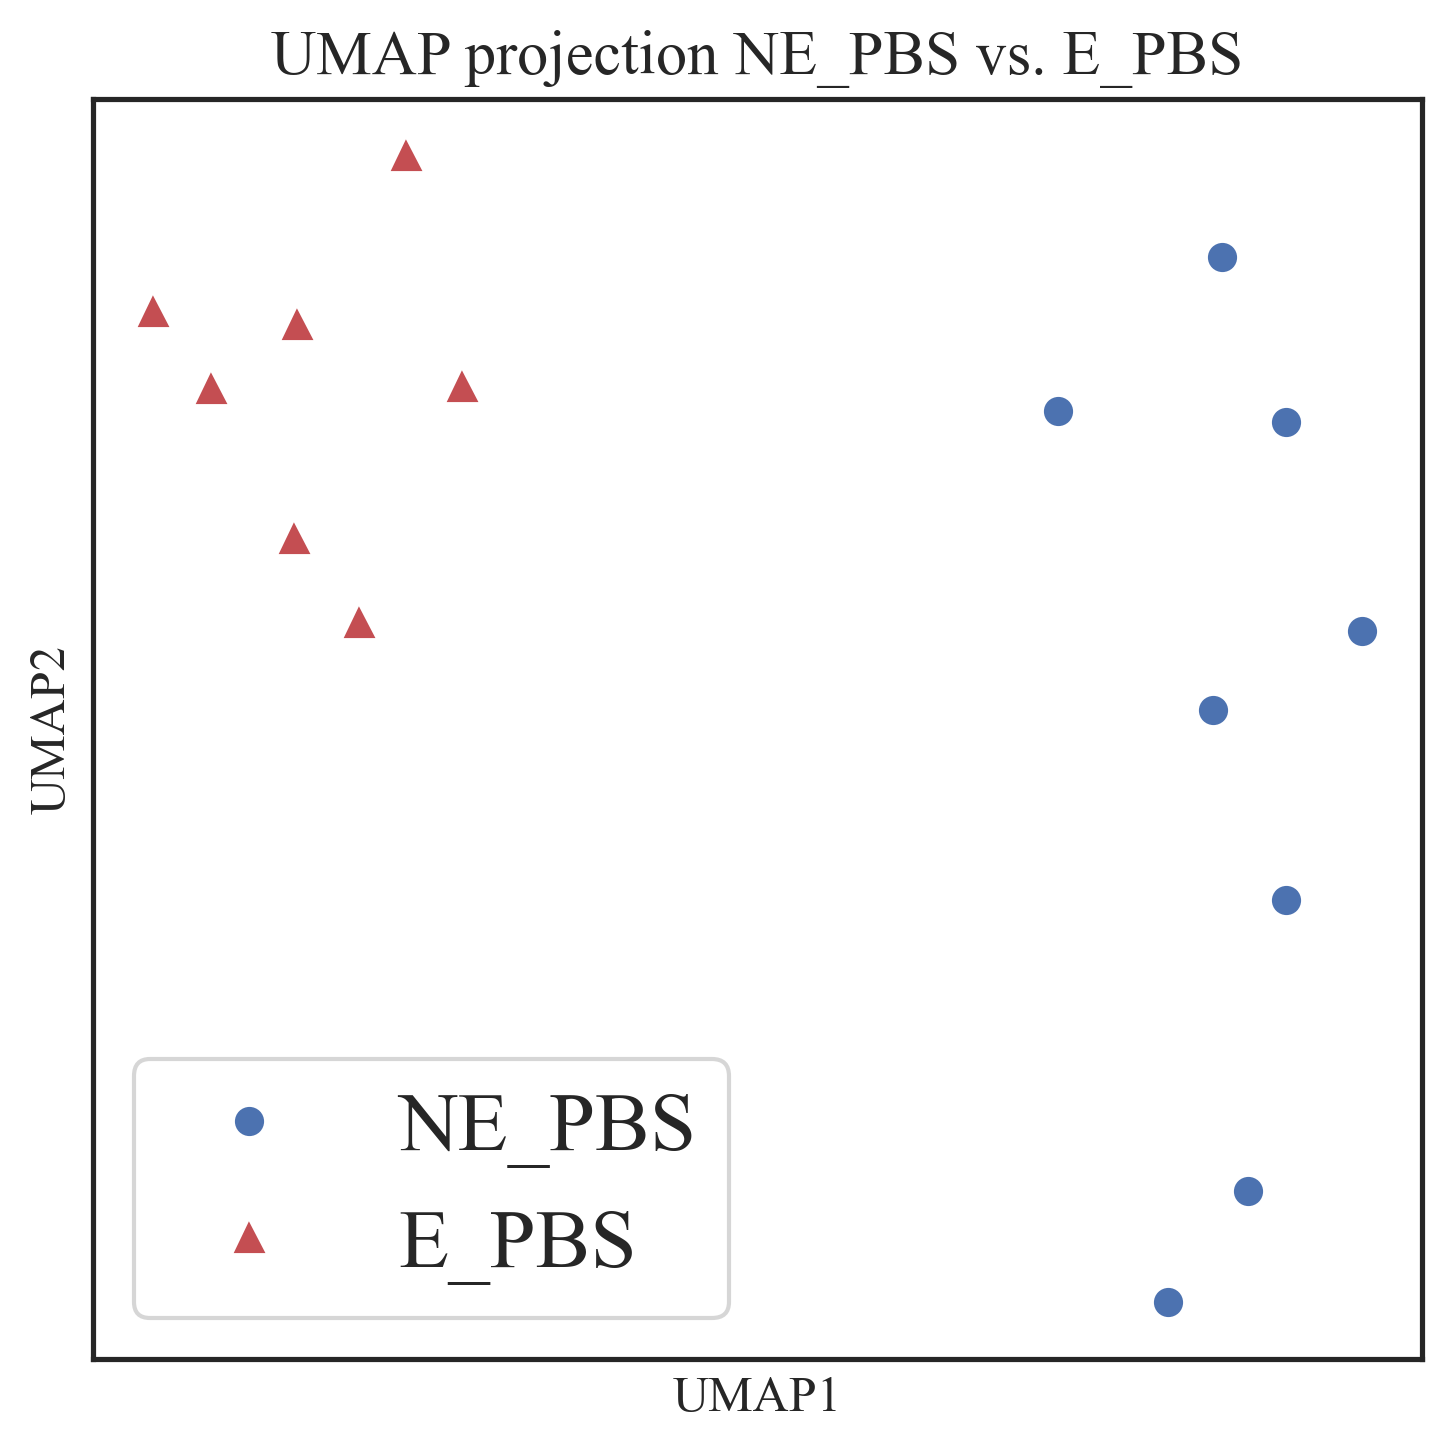

In [101]:
# Select features that separate NE_PBS (0) vs. E_PBS (2)
fs = ReliefF(n_neighbors = K, n_features_to_select = N_reliefF, n_jobs = -1, )
fs.fit(df_rna_normalized[mask_I].values, labels_I['Label'])
df_rna_relief = df_rna_normalized[df_rna_normalized.columns[fs.top_features_[:N_reliefF]]]
# Step 3: Plot UMAP of df_rna_relief
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_rna_relief)

# Plotting
x = embedding[:, 0]
y = embedding[:, 1]
plt.figure()
plt.plot(x[np.equal(labels_rna,0)], y[np.equal(labels_rna,0)], 'bo', label = "NE_PBS")
plt.plot(x[np.equal(labels_rna,2)], y[np.equal(labels_rna,2)], 'r^', label = "E_PBS")

plt.title('UMAP projection NE_PBS vs. E_PBS', fontsize=15)
plt.legend()
plt.xticks([])
plt.yticks([])  
plt.xlabel('UMAP1', fontsize=12)
plt.ylabel('UMAP2', fontsize=12)
plt.show()

In [102]:
df_rna_normalized.columns[fs.top_features_[:N_reliefF]]

Index(['Gm45235', 'F5', 'H2-M9', 'Gm44667', 'Gm9888', 'Slitrk3',
       '4921511C10Rik', 'Pla2g3', 'Smok4a', 'Susd3', 'Gm45091', 'Gm3500',
       'Gm15899', 'S100a7a', 'Mx2', 'Gm15981', '4932435O22Rik', 'Fbxo24',
       'Hmgb1-ps4', 'Gm8221', 'Drd1', '4930584E12Rik', 'Rpl19-ps3',
       '4930550C14Rik', 'Gm16183', 'Pira12', 'Il18r1', 'Gm12494', 'Gm14706',
       'A230065N10Rik', 'Gm13868', 'Gm43653', 'Clec4b1', 'Gm9791',
       '2500004C02Rik', 'Gm37969', 'Gm26789', '1700001G11Rik', 'Gm12454',
       'Cyp11a1', 'Olfr461', 'Col10a1', 'Gm44280', 'Adam4', 'Gm31544', 'Cldn9',
       'Gm35048', 'Havcr2', 'Gm6155', 'Gm12407', 'Vnn3', 'Gm37879', 'Ncam2',
       'E130218I03Rik', 'Uchl4', 'Gm36199', 'Hgf', 'Celf4', 'Gm1673', 'Gm7589',
       'Gm3373', 'Gm8700', 'Gm38245', 'Gm10676', 'Gm4799', 'Sapcd1', 'P2ry13',
       'Cdk1', 'Mageb3', 'ENSMUSG00000104917', 'Stac2', 'Gm43578',
       '5830416I19Rik', 'Gm11604', 'Gm16172', 'Gm35638', 'AV039307', 'Gm9130',
       'Gm47088', 'Gm26682', 'Myo7b', '

In [103]:
def train_evaluate_model(data, labels, n_estimators=1000, max_depth=3, verbose=False):
    loo = LeaveOneOut()
    predictions = []
    true_labels = []
    total = loo.get_n_splits(data)
    
    # for train_index, test_index in loo.split(data):
    for fold, (train_index, test_index) in enumerate(loo.split(data), 1):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = labels.iloc[train_index].values.ravel(), labels.iloc[test_index].values.ravel()
        
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        predictions.append(y_pred[0])
        true_labels.append(y_test[0])

        if verbose:
            print(f"Fold {fold}/{total}: Test index {test_index}, True label {y_test[0]}, Predicted label {y_pred[0]}")
    
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

In [104]:
# Train and evaluate models
print("\nTraining and evaluating on Prot Normalized dataset:")
acc_prot_normalized = train_evaluate_model(df_prot_normalized[mask_I], labels_I, n_estimators=5000, verbose=True)
print("\nTraining and evaluating on Prot Relief dataset:")
acc_prot_relief = train_evaluate_model(df_prot_relief[mask_I], labels_I, n_estimators=1000, verbose=True)
print("\nTraining and evaluating on RNA Normalized dataset:")
acc_rna_normalized = train_evaluate_model(df_rna_normalized[mask_I], labels_I, n_estimators=5000, verbose=True)
print("\nTraining and evaluating on RNA Relief dataset:")
acc_rna_relief = train_evaluate_model(df_rna_relief[mask_I], labels_I, n_estimators=1000, verbose=True)

# Merging the dataframes
df_multiomic_normalized = pd.concat([df_prot_normalized[mask_I], df_rna_normalized[mask_I]], axis=1)
df_multiomic_relief = pd.concat([df_prot_relief[mask_I], df_rna_relief[mask_I]], axis=1)

# Assuming labels_prot and labels_rna are the same, otherwise, use the appropriate labels for the merged data
print("\nTraining and evaluating on Multiomic Normalized dataset:")
acc_multiomic_normalized = train_evaluate_model(df_multiomic_normalized, labels_I, n_estimators=10000, verbose=True)
print("\nTraining and evaluating on Multiomic Relief dataset:")
acc_multiomic_relief = train_evaluate_model(df_multiomic_relief, labels_I, n_estimators=1000, verbose=True)


Training and evaluating on Prot Normalized dataset:
Fold 1/15: Test index [0], True label 0.0, Predicted label 1.0
Fold 2/15: Test index [1], True label 0.0, Predicted label 1.0
Fold 3/15: Test index [2], True label 0.0, Predicted label 1.0
Fold 4/15: Test index [3], True label 0.0, Predicted label 1.0
Fold 5/15: Test index [4], True label 0.0, Predicted label 1.0
Fold 6/15: Test index [5], True label 0.0, Predicted label 1.0
Fold 7/15: Test index [6], True label 0.0, Predicted label 0.0
Fold 8/15: Test index [7], True label 0.0, Predicted label 0.0
Fold 9/15: Test index [8], True label 1.0, Predicted label 0.0
Fold 10/15: Test index [9], True label 1.0, Predicted label 0.0
Fold 11/15: Test index [10], True label 1.0, Predicted label 1.0
Fold 12/15: Test index [11], True label 1.0, Predicted label 0.0
Fold 13/15: Test index [12], True label 1.0, Predicted label 0.0
Fold 14/15: Test index [13], True label 1.0, Predicted label 0.0
Fold 15/15: Test index [14], True label 1.0, Predicted l

In [107]:
# Collect the results in a dataframe
results_I = pd.DataFrame({
    'Dataset': ['Prot without feature selection', 'Prot with feature selection', 'RNA without feature selection', 'RNA with feature selection', 'Multiomic without feature selection', 'Multiomic with feature selection'],
    'Accuracy': [acc_prot_normalized, acc_prot_relief, acc_rna_normalized, acc_rna_relief, acc_multiomic_normalized, acc_multiomic_relief]
})

print(results_I)

                               Dataset  Accuracy
0       Prot without feature selection  0.200000
1          Prot with feature selection  0.866667
2        RNA without feature selection  0.466667
3           RNA with feature selection  1.000000
4  Multiomic without feature selection  0.400000
5     Multiomic with feature selection  1.000000


In [108]:
# Apply mask to the DataFrame and labels
df_prot_normalized_subset = df_prot_normalized[mask_I]

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Unidimensional SVMs
uni_accuracies = {}

for column in df_prot_normalized_subset.columns:
    correct_predictions = 0
    total_predictions = 0
    
    for train_index, test_index in loo.split(df_prot_normalized_subset):
        X_train, X_test = df_prot_normalized_subset.iloc[train_index], df_prot_normalized_subset.iloc[test_index]
        y_train, y_test = labels_I.iloc[train_index], labels_I.iloc[test_index]
        
        X_train_col = X_train[[column]]
        X_test_col = X_test[[column]]
        
        model = svm.SVC(kernel='linear')
        model.fit(X_train_col, y_train.values.ravel())  # Flatten y_train to 1D array
        
        y_pred = model.predict(X_test_col)
        
        if y_pred[0] == y_test.values.ravel()[0]:  # Flatten y_test to 1D array
            correct_predictions += 1
        total_predictions += 1
    
    accuracy = correct_predictions / total_predictions
    uni_accuracies[column] = accuracy

output_dir = "../Output"

# Save uni_accuracies to CSV
uni_accuracies_df = pd.DataFrame(list(uni_accuracies.items()), columns=['Feature', 'Accuracy'])
uni_accuracies_df.to_csv(os.path.join(output_dir, 'uni_accuracies.csv'), index=False)

print("Unidimensional SVM Accuracies saved to ../Output/uni_accuracies.csv")

Unidimensional SVM Accuracies saved to ../Output/uni_accuracies.csv


# CASE II - NE_PBS (0) vs. NE_AmAc (1)

c:\Users\fetsuruk\AppData\Local\anaconda3\envs\CCF\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


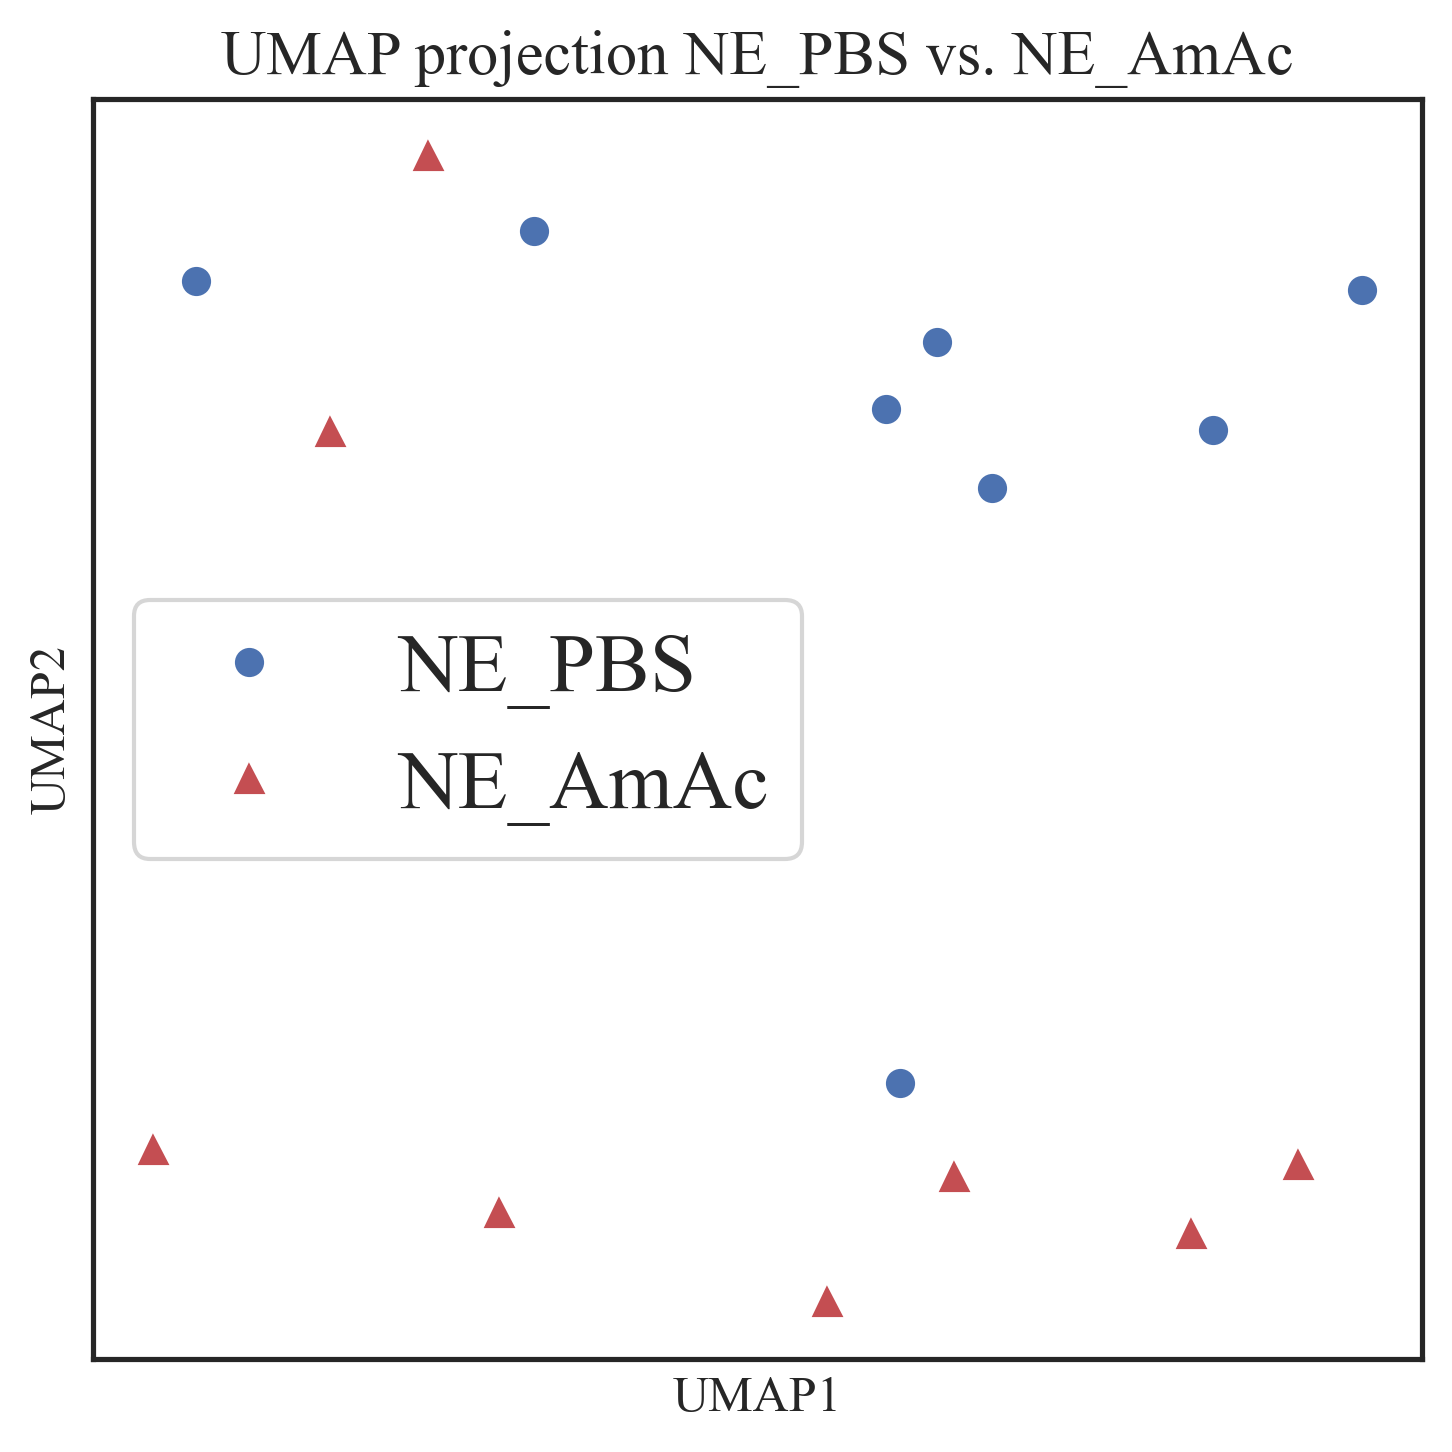

In [109]:
# Select features that separate NE_PBS (0) vs. NE_AmAc (1)
fs = ReliefF(n_neighbors = K, n_features_to_select = N_reliefF, n_jobs = -1, )
fs.fit(df_prot_normalized[mask_II].values, labels_II['Label'])
df_prot_relief = df_prot_normalized[df_prot_normalized.columns[fs.top_features_[:N_reliefF]]]
# Step 3: Plot UMAP of df_prot_relief
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_prot_relief)

# Plotting
x = embedding[:, 0]
y = embedding[:, 1]
plt.figure()
plt.plot(x[np.equal(labels_rna,0)], y[np.equal(labels_rna,0)], 'bo', label = "NE_PBS")
plt.plot(x[np.equal(labels_rna,1)], y[np.equal(labels_rna,1)], 'r^', label = "NE_AmAc")

plt.title('UMAP projection NE_PBS vs. NE_AmAc', fontsize=15)
plt.legend()
plt.xticks([])
plt.yticks([])  
plt.xlabel('UMAP1', fontsize=12)
plt.ylabel('UMAP2', fontsize=12)
plt.show()

In [110]:
df_prot_normalized.columns[fs.top_features_[:N_reliefF]]

Index(['Uggt1', 'Mrpl19', 'Dazap1', 'Slc27a1', 'Acot9', 'Capza2', 'Cdc37',
       'Clpp', 'Ctbp1', 'Gtf2i', 'Fkbp3', 'Rbm39', 'Eif4b', 'Syncrip',
       'Akr1c6', 'Dbn1', 'Mrpl14', 'Cobl', 'Smc3', 'Bsg', 'Gcdh', 'Adhfe1',
       'Pepd', 'Cwc22', 'Col6a6', 'Clic5', 'Txnl1', 'Cisd1', 'Aldoc', 'Abhd5',
       'H1-5', 'Ica', 'Ppp1r12b', 'Mecr', 'Mgst3', 'Mpc1', 'H2az1', 'Gstz1',
       'Tmsb10', 'Atl3', 'Eif3d', 'Tmem65', 'Eif2s3x', 'Hmgb2', 'Fn3krp',
       'Tmed5', 'Agk', 'Cfd', 'Pla2g7', 'Rbbp7', 'Cnp', 'Tceal5', 'Usp13',
       'Samm50', 'Iba57', 'Ybx3', 'Clic1', 'Tomm40', 'Bcat2', 'Nubp2', 'Ldhc',
       'Pgm2l1', 'Ttc1', 'Eif2b4', 'Ace', 'Acad10', 'Sdhd', 'Rps16', 'Cyc1',
       'Sp100', 'Ldb3', 'Ampd1', 'Ppil1', 'Hnrnph1', 'Scoc', 'Plin5', 'Rras2',
       'Eif2s2', 'Reep5', 'Ube2f', 'Ociad1', 'Ciao2b', 'Fdps', 'Cat', 'Srrm1',
       'Rpl4', 'Pmpca', 'Zc3h15', 'Rcc1', 'Chchd3', 'Fdx2', 'Eif1', 'Cox6c',
       'Rad21', 'H1-0', 'Nmral1', 'Nnt', 'Ssb', 'Dnajc11', 'Snx6'],
      dtype='o

c:\Users\fetsuruk\AppData\Local\anaconda3\envs\CCF\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


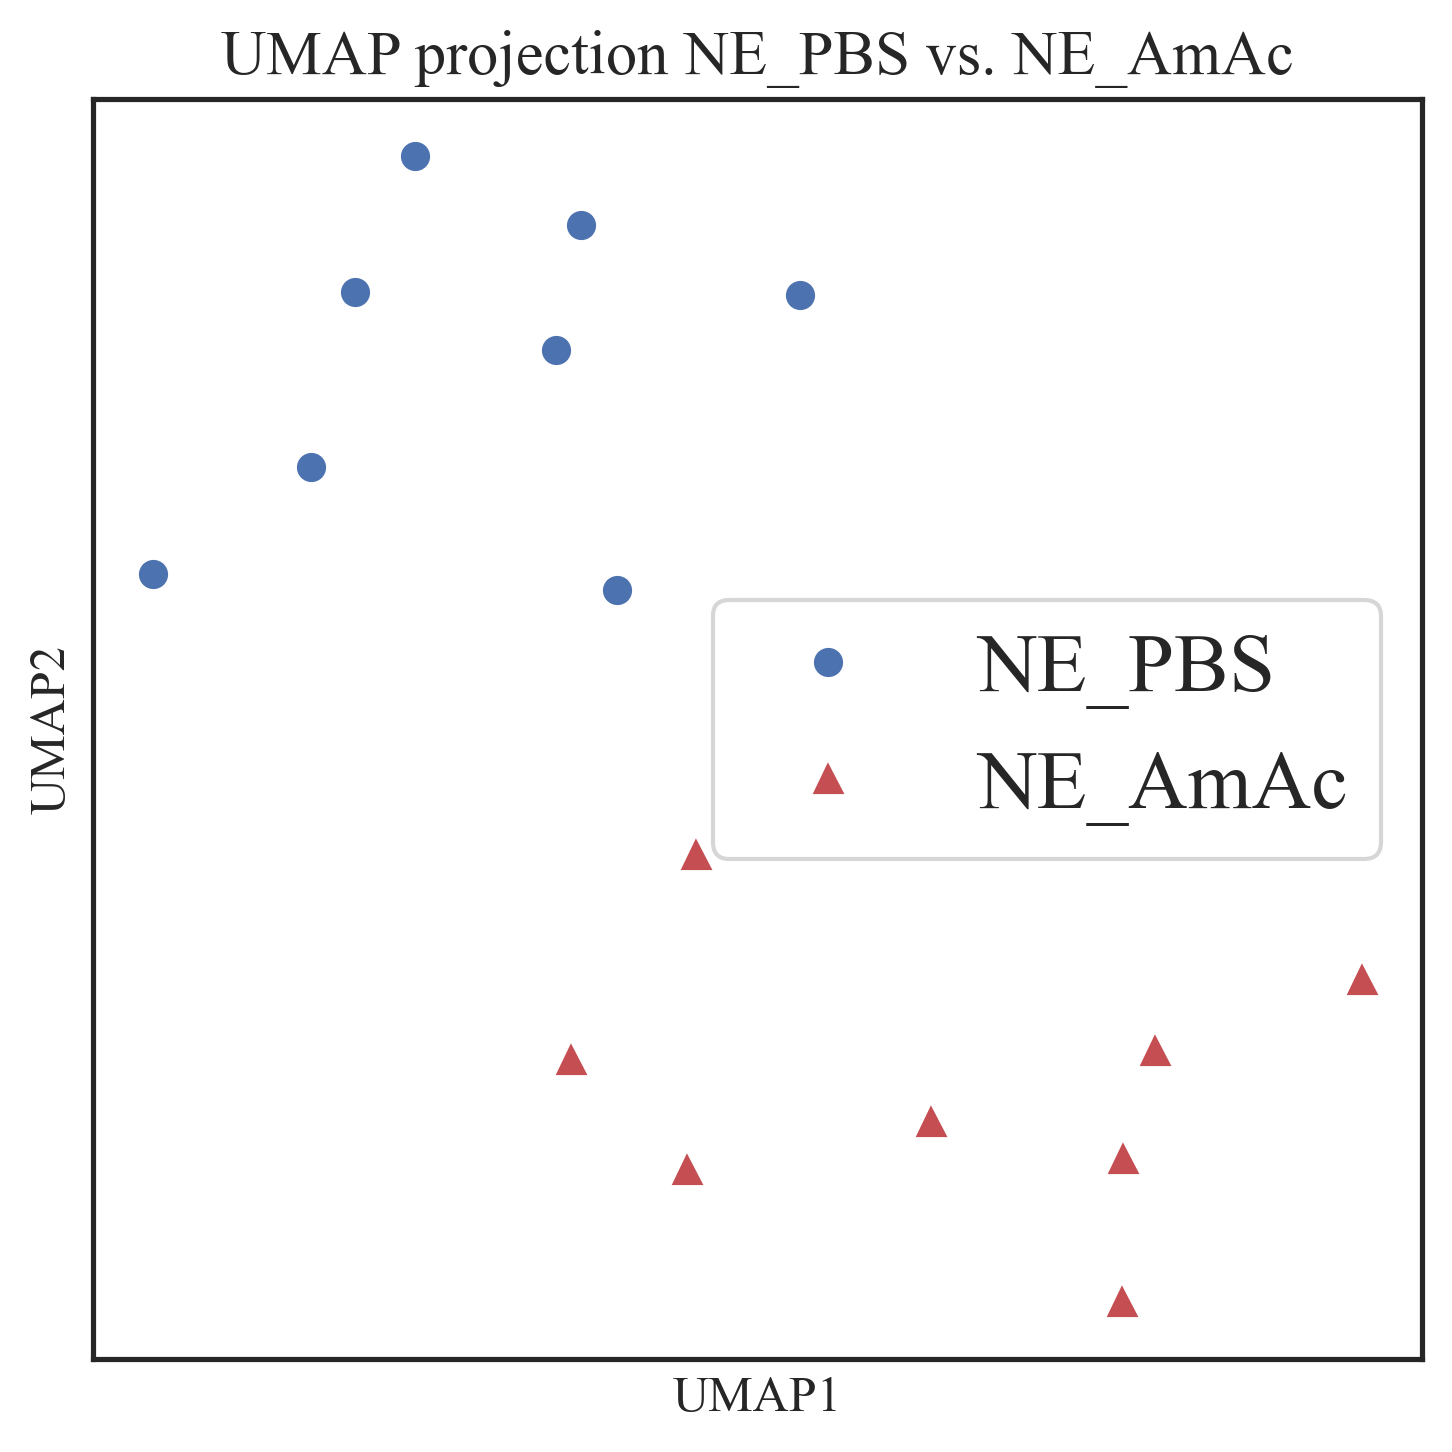

In [111]:
# Select features that separate NE_PBS (0) vs. NE_AmAc (1)
fs = ReliefF(n_neighbors = K, n_features_to_select = N_reliefF, n_jobs = -1, )
fs.fit(df_rna_normalized[mask_II].values, labels_II['Label'])
df_rna_relief = df_rna_normalized[df_rna_normalized.columns[fs.top_features_[:N_reliefF]]]
# Step 3: Plot UMAP of df_rna_relief
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_rna_relief)

# Plotting
x = embedding[:, 0]
y = embedding[:, 1]
plt.figure()
plt.plot(x[np.equal(labels_rna,0)], y[np.equal(labels_rna,0)], 'bo', label = "NE_PBS")
plt.plot(x[np.equal(labels_rna,1)], y[np.equal(labels_rna,1)], 'r^', label = "NE_AmAc")

plt.title('UMAP projection NE_PBS vs. NE_AmAc', fontsize=15)
plt.legend()
plt.xticks([])
plt.yticks([])  
plt.xlabel('UMAP1', fontsize=12)
plt.ylabel('UMAP2', fontsize=12)
plt.show()

In [112]:
df_rna_normalized.columns[fs.top_features_[:N_reliefF]]

Index(['Gm37587', 'Gm37248', 'Gm10479', 'Fibcd1', 'Gm14853', 'Gm42466',
       'Gm9311', 'Gm42508', 'Pgk1-ps1', 'Akr1c19', 'Rpl31-ps1', 'Gm22580',
       'Gm11604', 'Gm5511', 'Gm49017', 'Gm42513', 'Gm9864', 'Gm20681',
       'D330050I16Rik', 'Spo11', 'Gm6035', 'Myrfl', 'Lrp8', '1110035H17Rik',
       'Gm45805', 'Stoml3', 'mt-Ta', 'A230072E10Rik', 'Gm4613',
       '4930599N24Rik', 'Pkhd1', 'Gm9874', 'Gm8700', 'Gm47798', 'Gm11719',
       'Pcdhgc5', 'Mir692-1', 'Gm19684', 'Gm8108', 'Htr2b', 'Cntn1',
       '4932435O22Rik', 'Rpl31-ps16', '6030466F02Rik', 'Gm43096', 'Gm3752',
       'Adnp', 'Gm11830', 'Gm14400', 'Gm48496', 'ENSMUSG00002075580',
       'Gm48890', 'Spcs2-ps', 'Spinkl', 'Gm15713', 'Slc17a8', '7330404K18Rik',
       'Gm15533', 'Cfap44', 'Ube2nl', 'Gm29776', 'Tmprss9', 'Gm8717', 'Gm4813',
       'Gm43355', 'Cacna1e', 'Gm49490', 'Gm15785', 'Gm42659', 'Gm29397',
       'Gm49484', 'Gm10748', 'Gm18890', 'Scarna17', 'H2al1k', 'Ttk', 'Gm44668',
       'Efna3', 'Gm13373', 'Gm11592', '

In [113]:
# Train and evaluate models
print("\nTraining and evaluating on Prot Normalized dataset:")
acc_prot_normalized = train_evaluate_model(df_prot_normalized[mask_II], labels_II, n_estimators=5000, verbose=True)
print("\nTraining and evaluating on Prot Relief dataset:")
acc_prot_relief = train_evaluate_model(df_prot_relief[mask_II], labels_II, n_estimators=1000, verbose=True)
print("\nTraining and evaluating on RNA Normalized dataset:")
acc_rna_normalized = train_evaluate_model(df_rna_normalized[mask_II], labels_II, n_estimators=5000, verbose=True)
print("\nTraining and evaluating on RNA Relief dataset:")
acc_rna_relief = train_evaluate_model(df_rna_relief[mask_II], labels_II, n_estimators=1000, verbose=True)

# Merging the dataframes
df_multiomic_normalized = pd.concat([df_prot_normalized[mask_II], df_rna_normalized[mask_II]], axis=1)
df_multiomic_relief = pd.concat([df_prot_relief[mask_II], df_rna_relief[mask_II]], axis=1)

# Assuming labels_prot and labels_rna are the same, otherwise, use the appropriate labels for the merged data
print("\nTraining and evaluating on Multiomic Normalized dataset:")
acc_multiomic_normalized = train_evaluate_model(df_multiomic_normalized, labels_II, n_estimators=10000, verbose=True)
print("\nTraining and evaluating on Multiomic Relief dataset:")
acc_multiomic_relief = train_evaluate_model(df_multiomic_relief, labels_II, n_estimators=1000, verbose=True)


Training and evaluating on Prot Normalized dataset:
Fold 1/16: Test index [0], True label 0.0, Predicted label 0.0
Fold 2/16: Test index [1], True label 0.0, Predicted label 1.0
Fold 3/16: Test index [2], True label 0.0, Predicted label 1.0
Fold 4/16: Test index [3], True label 0.0, Predicted label 0.0
Fold 5/16: Test index [4], True label 0.0, Predicted label 0.0
Fold 6/16: Test index [5], True label 0.0, Predicted label 1.0
Fold 7/16: Test index [6], True label 0.0, Predicted label 1.0
Fold 8/16: Test index [7], True label 0.0, Predicted label 0.0
Fold 9/16: Test index [8], True label 1.0, Predicted label 1.0
Fold 10/16: Test index [9], True label 1.0, Predicted label 0.0
Fold 11/16: Test index [10], True label 1.0, Predicted label 0.0
Fold 12/16: Test index [11], True label 1.0, Predicted label 1.0
Fold 13/16: Test index [12], True label 1.0, Predicted label 0.0
Fold 14/16: Test index [13], True label 1.0, Predicted label 1.0
Fold 15/16: Test index [14], True label 1.0, Predicted l

In [119]:
# Collect the results in a dataframe
results_II = pd.DataFrame({
    'Dataset': ['Prot without feature selection', 'Prot with feature selection', 'RNA without feature selection', 'RNA with feature selection', 'Multiomic without feature selection', 'Multiomic with feature selection'],
    'Accuracy': [acc_prot_normalized, acc_prot_relief, acc_rna_normalized, acc_rna_relief, acc_multiomic_normalized, acc_multiomic_relief]
})

print(results_II)

                               Dataset  Accuracy
0       Prot without feature selection    0.5000
1          Prot with feature selection    0.7500
2        RNA without feature selection    0.2500
3           RNA with feature selection    0.9375
4  Multiomic without feature selection    0.4375
5     Multiomic with feature selection    0.8125


In [114]:
# # Step 1: Plot UMAP of df_prot_normalized
# reducer = umap.UMAP(random_state=42)
# embedding = reducer.fit_transform(df_prot_normalized)

# # Convert to a DataFrame for easier manipulation
# embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
# embedding_df['Label'] = labels_prot

# # Plotting
# plt.figure(figsize=(10, 8))
# scatter = sns.scatterplot(
#     x='UMAP1', y='UMAP2',
#     hue='Label', palette='viridis', data=embedding_df,
#     s=100, alpha=0.8, edgecolor='k'
# )

# plt.title('UMAP projection of the tissue proteomics data', fontsize=15)
# #plt.legend(['NE PBS', 'NE AmAc', 'E PBS', 'E AmAc'],title='Labels',title_fontsize='13', loc='best', fontsize='11')
# plt.legend(title='Labels',title_fontsize='13', loc='best', fontsize='11')
# plt.xticks([])
# plt.yticks([])  
# plt.xlabel('UMAP1', fontsize=12)
# plt.ylabel('UMAP2', fontsize=12)
# plt.show()

In [115]:
# # Step 1: Plot UMAP of df_rna_normalized
# reducer = umap.UMAP(random_state=42)
# embedding = reducer.fit_transform(df_rna_normalized)

# # Convert to a DataFrame for easier manipulation
# embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
# embedding_df['Label'] = labels_rna

# # Plotting
# plt.figure(figsize=(10, 8))
# scatter = sns.scatterplot(
#     x='UMAP1', y='UMAP2',
#     hue='Label', palette='viridis', data=embedding_df,
#     s=100, alpha=0.8, edgecolor='k'
# )

# plt.title('UMAP projection of the tissue RNASeq data', fontsize=15)
# #plt.legend(['NE PBS', 'NE AmAc', 'E PBS', 'E AmAc'],title='Labels',title_fontsize='13', loc='best', fontsize='11')
# plt.legend(title='Labels',title_fontsize='13', loc='best', fontsize='11')
# plt.xticks([])
# plt.yticks([])  
# plt.xlabel('UMAP1', fontsize=12)
# plt.ylabel('UMAP2', fontsize=12)
# plt.show()

In [116]:
# def get_gene_name(ensembl_gene_id):
#     url = f"https://rest.ensembl.org/lookup/id/{ensembl_gene_id}?content-type=application/json"
#     response = requests.get(url)
    
#     if response.status_code == 200:
#         data = response.json()
#         return data.get('display_name')
#     else:
#         return None

# def get_gene_names(ensembl_gene_ids):
#     gene_names = {}
#     for gene_id in ensembl_gene_ids:
#         gene_name = get_gene_name(gene_id)
#         gene_names[gene_id] = gene_name if gene_name else "Not found"
#     return gene_names

In [117]:
# # Select features that separate PBS (0 & 2) vs. AmAc (1 & 3)
# fs = ReliefF(n_neighbors = K, n_features_to_select = N_reliefF, n_jobs = -1, )
# fs.fit(df_rna_normalized.values, np.array([False] * 8 + [True] * 8 + [False] * 7 + [True] * 8))
# df_relief = df_rna_normalized[df_rna_normalized.columns[fs.top_features_[:N_reliefF]]]
# # Step 3: Plot UMAP of df_relief
# reducer = umap.UMAP(random_state=42)
# embedding = reducer.fit_transform(df_relief)

# # Plotting
# x = embedding[:, 0]
# y = embedding[:, 1]
# plt.figure()
# plt.plot(x[np.equal(labels_rna,0)], y[np.equal(labels_rna,0)], 'bo', label = "PBS")
# plt.plot(x[np.equal(labels_rna,2)], y[np.equal(labels_rna,2)], 'bo', label = "PBS")
# plt.plot(x[np.equal(labels_rna,1)], y[np.equal(labels_rna,1)], 'r^', label = "AmAc")
# plt.plot(x[np.equal(labels_rna,3)], y[np.equal(labels_rna,3)], 'r^', label = "AmAc")

# plt.title('UMAP projection of PBS vs. AmAc', fontsize=15)
# plt.xticks([])
# plt.yticks([])  
# plt.xlabel('UMAP1', fontsize=12)
# plt.ylabel('UMAP2', fontsize=12)
# plt.show()